In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [7]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [8]:
import torch

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [11]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1


(-0.5, 26.5, 26.5, -0.5)

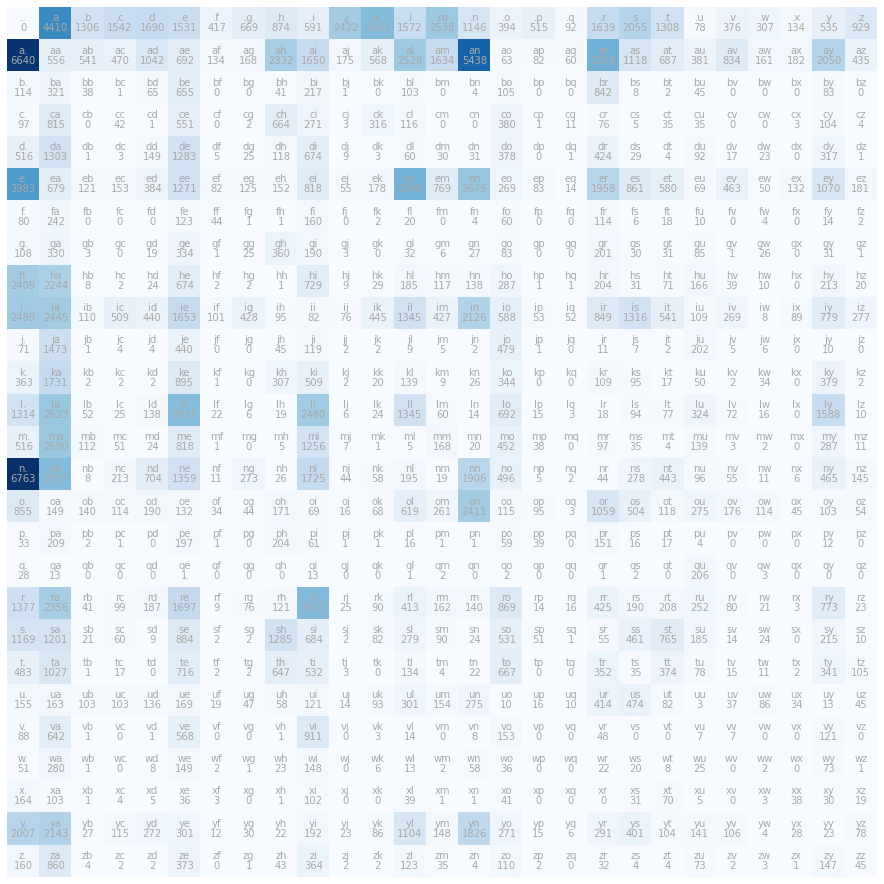

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='darkgray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='darkgray')
plt.axis('off')

In [28]:
P = (N + 1).float()
P /= P.sum(1, keepdim=True)

In [29]:
g = torch.Generator().manual_seed(42)
for i in range(5):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
    # print('generator state:', g.get_state()[:10])

a.
a.
keys.
a.
hmone.


In [31]:
log_likelihood = 0.0
normalizer = 0
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        log_prob = torch.log(P[ix1, ix2])
        log_likelihood += log_prob
        normalizer += 1

nll = -log_likelihood
normalized_nll = nll / normalizer
print(f'{log_likelihood=} ')
print(f'{nll=} ')
print(f'{normalized_nll=} ')

log_likelihood=tensor(-27.8672) 
nll=tensor(27.8672) 
normalized_nll=tensor(3.4834) 


In [36]:
import torch.nn.functional as F

In [74]:
# create the training set of bigrams

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)


In [79]:
for k in range(69):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    #update the weights
    W.data += -69 * W.grad

2.473687171936035
2.4733550548553467
2.4730331897735596
2.4727208614349365
2.4724180698394775
2.4721248149871826
2.471839189529419
2.471562147140503
2.4712932109832764
2.471031665802002
2.4707775115966797
2.4705307483673096
2.470290184020996
2.4700562953948975
2.4698286056518555
2.469606637954712
2.469391345977783
2.4691808223724365
2.4689760208129883
2.4687764644622803
2.4685821533203125
2.4683918952941895
2.4682071208953857
2.4680263996124268
2.4678499698638916
2.4676780700683594
2.467510223388672
2.467345952987671
2.4671857357025146
2.467029333114624
2.466876268386841
2.466726541519165
2.466580629348755
2.466437339782715
2.4662973880767822
2.466160297393799
2.466026782989502
2.465895414352417
2.4657669067382812
2.4656412601470947
2.4655182361602783
2.465397357940674
2.4652793407440186
2.465163469314575
2.4650497436523438
2.4649386405944824
2.464829444885254
2.4647226333618164
2.4646174907684326
2.46451473236084
2.464413642883301
2.4643142223358154
2.464216947555542
2.464121580123901